<a href="https://colab.research.google.com/github/Stray-Weights/Dlthon_01_Motocycle_Night_Ride/blob/main/hang-ah/%EC%8B%9C%EC%8A%A4%ED%85%9C%ED%86%B5%ED%95%A9vr1_by_%EB%B0%95%ED%95%AD%EC%95%84.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Step.0 - 라이브러리 임포트

어떤 모델을 사용하든 공통적으로 설치 & 임포트되어야 할 패키지, 라이브러리, 모듈 선언 부

In [1]:
from IPython.display import clear_output, HTML, display

! pip install opencv-python
clear_output()

In [2]:
from dotenv import load_dotenv
import cv2
import os
import json
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T
from torchvision.transforms import InterpolationMode
from dotenv import load_dotenv

In [3]:
# Device 설정 - 코랩의 GPU 사용 여부 체크
# [런타임] - [런타임 유형 변경]에서 T4 GPU 선택 권장
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(f"현재 사용 중인 장치: {device}")

현재 사용 중인 장치: cuda


## Step.1 - 데이터 전처리

### 1-02. PathManager 클래스 선언

1, 2번 중 자신의 환경에 맞는 코드만 실행

#### 1) PathManager 선언 (구글 드라이브용)

In [4]:
# 종하님의 코드를 구글 드라이브 사용자에 맞게 변경   by 박항아
class PathManager:

    def __init__(self, project_path: str | Path, data_path: str, default_size: int | None = None):
        # 1. 경로를 Path 객체로 변환 (유연성 확보)
        self.root_path = Path(project_path)
        self.data_path = data_path
        self.default_size = default_size

        # 2. .env 로드
        self.dotenv_path = self.root_path / ".env"
        load_dotenv(self.dotenv_path)

        # 3. 디렉토리 경로 설정
        self._images_dir = self.root_path / data_path / 'images'
        self._models_dir = self.root_path / 'models'
        self._datas_dir = self.root_path / data_path

        # 4. 자동 폴더 생성 로직 추가
        self._make_dirs()

    def _find_root(self, marker: str = ".env") -> Path:
        """현재 작업 디렉토리부터 상위로 올라가며 마커(.env)가 있는 최상단 경로 반환"""
        current_cwd = Path().cwd().resolve()

        # 현재 디렉토리에 마커가 있는지도 확인 포함
        if (current_cwd / marker).exists():
            return current_cwd

        for parent in current_cwd.parents:
            if (parent / marker).exists():
                return parent

        # 마커를 못 찾을 경우 현재 디렉토리 반환
        return current_cwd

    def _make_dirs(self):
        """필요한 디렉토리가 없으면 생성합니다."""
        target_dirs = [self._images_dir, self._models_dir, self._datas_dir]
        for path in target_dirs:
            # exist_ok=True: 이미 폴더가 있어도 에러를 발생시키지 않음
            # parents=True: 상위 폴더가 없으면 상위까지 한꺼번에 생성
            path.mkdir(parents=True, exist_ok=True)
            print(f"준비 완료: {path}")

    # --- 경로 획득 메서드 ---

    def get_image_path(self, image_name: str) -> Path:
        """이미지 주소 획득"""
        self.image_name = image_name
        return self._images_dir / image_name

    def get_model_path(self, model_name: str) -> Path:
        """모델 주소 획득"""
        self.model_name = model_name
        return self._models_dir / model_name

    def get_data_path(self, data_name: str) -> Path:
        """데이터 주소 획득"""
        self.data_name = data_name
        return self._datas_dir / data_name

#### 2) PathManager 선언 (로컬 사용자)

In [ ]:
class PathManager:
    """환경 및 모듈 간 규격 클래스"""
    """상황에 맞게 경로와 규격을 수정 후 사용할 것"""

    def __init__(self, default_size: int | None = None):
        """dotenv 위치 찾기 + 로드"""
        self.root_path = self._find_root()
        self.dotenv_path = self.root_path / ".env" # 또는 self.dotenv_path = self.root_path / ".env"
        load_dotenv(self.dotenv_path)

        """이미지와 모델 디렉토리 인식"""
        self._images_dir = self.root_path / "data/images"
        self._models_dir = self.root_path / "models"
        self._datas_dir = self.root_path / "data"
        self.default_size = default_size

        self.image_name = None
        self.model_name = None

    def _find_root(self, marker: str=".env") -> Path: # 외부에서 호출할 일 없다.
        """프로젝트 최상단 경로를 찾는 함수"""
        """.env를 마커로 사용"""
        current_cwd = Path().cwd().resolve()
        for parent in current_cwd.parents:
            if (parent / marker).exists():
                return parent

    def get_image_path(self, image_name: str) -> Path:
        """이미지 주소 획득"""
        self.image_name = image_name
        return self._images_dir / image_name

    def get_model_path(self, model_name: str) -> Path:
        """모델 주소 획득"""
        self.model_name = model_name
        return self._models_dir / model_name

    def get_data_path(self, data_name: str) -> Path:
        """데이터 주소 획득"""
        self.data_name = data_name
        return self._datas_dir / data_name

### 1-03. PathManager 실행(로컬 or 드리이브 상 데이터 연결)

#### 0) 드라이브 연결 (코렙 사용자만 실행)

In [5]:
# 드라이브 경로 설정  by 박항아
drive_path = '#Study/Aiffel/Work' # 평상시 작업하는 드라이브 폴더 경로를 입력해 주세요.
project_name = 'motorcycle'       # 이번 프로젝트세 사용하는 폴더명을 입력해주세요.
data_path = 'data' # 프로젝트 폴더 내에 데이터 폴더 경로를 입력해주세요.

In [ ]:
# 드라이브 연결  by 박항아
from google.colab import drive
from IPython.display import clear_output, display
import ipywidgets as widgets
import os

def inf(msg, style, wdth): inf = widgets.Button(description=msg, disabled=True, button_style=style, layout=widgets.Layout(min_width=wdth));display(inf)

# 1. 구글 드라이브 마운트
print("Connecting...")
drive.mount('/content/gdrive')

# 2. 경로 설정 및 폴더 생성
base_path = os.path.join('/content/gdrive/MyDrive',drive_path)
project_path = os.path.join(base_path, project_name)

# 3. 폴더 생성
print(f"Selected Google Drive root path: {base_path}")
inf('\u2714 Done','success', '50px')

In [7]:
# 4. 작업 디렉토리 이동 및 다운로드
# !cd 대신 %cd를 사용해야 이후의 명령어들이 이 경로에서 실행됩니다.
%cd "{project_path}"

/content/gdrive/MyDrive/#Study/Aiffel/Work/motorcycle


In [8]:
# 데이터가 풀린 경로의 파일 목록 확인
data_list = os.listdir(os.path.join(project_path, data_path))
print("데이터 폴더 내용물:", data_list)

데이터 폴더 내용물: ['www.acmeai.tech ODataset 1 - Motorcycle Night Ride Dataset.pdf', 'COCO_motorcycle (pixel).json', 'www.acmeai.tech ODataset 1 - Motorcycle Night Ride Dataset', 'images']


#### 1) 패스매니저 인스턴스 생성 및 경로 초기화
**로컬 혹은 드라이브 사용자에 따라 하단 4~5번 코드중 1개를 실행해주세요**

In [9]:
def run():
    """앞으로 작업할 모든 작업에서 쓰는 경로 반환 함수"""

    # path_manager = PathManager() # 로컬 사용자용
    path_manager = PathManager(project_path,data_path) # 드라이브 사용자용

    # 기본 경로, 이미지 폴더 경로, 데이터 폴더 경로
    root_path = path_manager.root_path
    images_dir = path_manager._images_dir
    data_dir = path_manager._datas_dir

    # 이미지 폴더 내의 이미지 경로
    my_image_path = path_manager.get_image_path("night ride (7).png")

    # 원본
    my_image_origin = cv2.imread(my_image_path)

    # 원본을 rgb로 변환 후 변수 저장
    my_image_rgb = cv2.cvtColor(my_image_origin, cv2.COLOR_BGR2RGB)

    # json 경로
    my_json_path = path_manager.get_data_path("COCO_motorcycle (pixel).json")

    # json 로드
    with open (my_json_path, "r", encoding="utf-8") as f:
        my_json_origin = json.load(f)

    return path_manager, root_path, images_dir, data_dir, my_json_origin

# root_path: .env 파일의 부모 폴더, images_dir: 이미지 폴더 주소, data_dir: 데이터 폴더 주소, my_json_origin: json파일 객체
pm, root_path, images_dir, data_dir, my_json_origin = run()

준비 완료: /content/gdrive/MyDrive/#Study/Aiffel/Work/motorcycle/data/images
준비 완료: /content/gdrive/MyDrive/#Study/Aiffel/Work/motorcycle/models
준비 완료: /content/gdrive/MyDrive/#Study/Aiffel/Work/motorcycle/data


#### 2) 이미지 파일 가져오기



In [10]:
import os

# 1. 이미지 폴더 내의 모든 파일 리스트업
# PathManager의 속성을 활용합니다.
all_files = os.listdir(images_dir)

# 2. 이미지 확장자만 필터링 (순서가 달라도 상관없습니다, 이름으로 매칭할 거니까요)
valid_extensions = ('.png', '.jpg', '.jpeg')
image_files = [f for f in all_files if f.lower().endswith(valid_extensions)]

print(f"찾은 이미지 개수: {len(image_files)}장") # 여기서 200이 나와야 합니다.

찾은 이미지 개수: 600장


In [11]:
# 1. 'save'와 'fuse'가 이름에 들어간 파일은 제외하고 순수 'night ride'와 'Screenshot'만 추출
# 리스트 컴프리헨션을 사용하여 조건부 필터링을 수행합니다.
image_files = [
    f for f in all_files
    if f.lower().endswith(valid_extensions)
    and 'save' not in f.lower()
    and 'fuse' not in f.lower()
]

print(f"정제된 이미지 개수: {len(image_files)}장")
# 여기서 정확히 200장이 나오는지 확인하십시오.

print(image_files[99])

정제된 이미지 개수: 200장
Screenshot (447).png


In [12]:
# JSON에 등록된 모든 파일 이름을 집합(Set)으로 만듭니다. (검색 속도 최적화)
json_filenames = {img['file_name'] for img in my_json_origin['images']}

# 폴더에는 있지만 JSON에는 없는 유령 파일들을 걸러냅니다.
final_image_files = [f for f in image_files if f in json_filenames]

print(f"최종 매칭된 이미지 개수: {len(final_image_files)}장")

최종 매칭된 이미지 개수: 200장


### 1-04. 훈련데이터와 검증 데이터 분리

In [13]:
from sklearn.model_selection import train_test_split

# 0. 팀원들끼리 공유할떄 시드값이 고정되어도 기본 파일정렬은 os마다 다를 수 있습니다. 그래서 추가했습니다.
final_image_files = sorted(final_image_files)

# 1. 전체 200장에서 먼저 Test 20장(10%)을 분리합니다.
# 200 * 0.1 = 20
train_val_files, test_files = train_test_split(
    final_image_files,
    test_size=0.1,
    random_state=2026
)

# 2. 남은 180장에서 다시 Val 20장(약 11.1%)을 분리합니다.
# 180 * (20/180) = 20
train_files, val_files = train_test_split(
    train_val_files,
    test_size=20/180,
    random_state=2026
)

print(f"✅ 분리 완료 (Seed: 2026)")
print(f"훈련 데이터(Train): {len(train_files)}장")
print(f"검증 데이터(Val): {len(val_files)}장")
print(f"테스트 데이터(Test): {len(test_files)}장")

✅ 분리 완료 (Seed: 2026)
훈련 데이터(Train): 160장
검증 데이터(Val): 20장
테스트 데이터(Test): 20장


### 1-05. 데이터셋 클래스 선언

#### 1) 데이터셋 정의

In [14]:
# 라이르러리 추가 임포트
import albumentations as A
from albumentations.pytorch import ToTensorV2


# 0번부터 5번까지 6개 클래스를 할당, 배경도 언Undrivable에 포함
CLASS_MAP = {
    'Undrivable': 0,
    'Road': 1,
    'Lane Mark': 2,
    'My bike': 3,
    'Rider': 4,
    'Moveable': 5
}
# 역매핑 (ID -> Name)은 필요할 때 내부에서 생성하거나 별도로 정의
ID_TO_NAME = {v: k for k, v in CLASS_MAP.items()}


class DeepLabDataset(Dataset):
    """데이터셋, 이미지 및 마스크크 리사이즈, 정규화, 텐서화 """

    def __init__(self, image_paths, json_data, class_map):
        self.image_paths = image_paths
        self.json_data = json_data
        self.class_map = class_map

        # 520x520 리사이즈 및 텐서 변환
        self.transform = A.Compose([
            A.Resize(528, 528, interpolation=cv2.INTER_LINEAR),
            A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
            ToTensorV2()
        ])

        # 마스크 전용 리사이즈 (정수 값 유지를 위해 별도 처리하거나 Compose 내에서 mask_interpolation 설정)
        self.mask_resize = A.Resize(528, 528, interpolation=cv2.INTER_NEAREST)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        """마스크 제너레이터 함수로 마스크 생성, 이미지와 마스크에 리사이즈 및 정규화 적용"""
        image_path = self.image_paths[idx]

        # 1. 원본 이미지 로드 및 bgr2rgb
        image = cv2.imread(str(image_path))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # 2. 마스크 생성 (기존에 정의한 6개 클래스 로직)
        # 2. 1920x1080 원본 크기로 먼저 생성
        full_mask = self._generate_full_mask(image_path.name, (1080, 1920))

        # 3. 이미지와 마스크 동시 변환 -> Resize(528, 528) 적용
        transformed = self.mask_resize(image=image, mask=full_mask)
        transformed = self.transform(image=transformed['image'], mask=transformed['mask'])

        return transformed['image'], transformed['mask'].long()

    def _generate_full_mask(self, file_name, shape):
        """JSON의 좌표를 기반으로 1080x1920 마스크 생성"""
        mask = np.zeros(shape, dtype=np.uint8)

        # 1. file_name으로 image_id 찾기
        image_info = next((img for img in self.json_data['images'] if img['file_name'] == file_name), None)
        if image_info is None:
            return mask

        image_id = image_info['id']

        # 2. 해당 image_id를 가진 모든 annotation 가져오기
        annotations = [ann for ann in self.json_data['annotations'] if ann['image_id'] == image_id]

        # 3. 카테고리 ID -> 이름 -> 인덱스(0~5) 매핑
        category_id_to_name = {cat['id']: cat['name'] for cat in self.json_data['categories']}

        for ann in annotations:
            cat_name = category_id_to_name.get(ann['category_id'])
            label_idx = self.class_map.get(cat_name)

            if label_idx is not None:
                for seg in ann['segmentation']:
                    # COCO 포맷의 폴리곤 [x1, y1, x2, y2...]을 numpy 배열로 변환
                    poly = np.array(seg).reshape((-1, 1, 2)).astype(np.int32)
                    # 해당 영역을 label_idx로 채움
                    cv2.fillPoly(mask, [poly], color=label_idx)
        return mask



#### 2) 내가 설정한 클래스맵과 json 내부의 클래스명 일치여부 확인

In [15]:
def check_categories(json_data):
    """위에서 정의한 CLASS_MAP객체의 키들이 JSON의 카테고리와 철자가 정확하게 맞는지 확인인"""
    # JSON 내부에 실제 등록된 카테고리 이름들 추출
    json_cat_names = [cat['name'] for cat in json_data.get('categories', [])]
    print(f"JSON 내 카테고리: {json_cat_names}")

    # 위에서 정의한 CLASS_MAP과 비교
    for name in CLASS_MAP.keys():
        if name not in json_cat_names:
            print(f"⚠️ 경고: '{name}' 클래스가 JSON에 존재하지 않습니다. 철자를 확인하세요.")
        else:
            print(f"✅ 확인: '{name}' 매칭 완료.")

# 실행
check_categories(my_json_origin)

JSON 내 카테고리: ['Rider', 'My bike', 'Moveable', 'Lane Mark', 'Road', 'Undrivable']
✅ 확인: 'Undrivable' 매칭 완료.
✅ 확인: 'Road' 매칭 완료.
✅ 확인: 'Lane Mark' 매칭 완료.
✅ 확인: 'My bike' 매칭 완료.
✅ 확인: 'Rider' 매칭 완료.
✅ 확인: 'Moveable' 매칭 완료.


### 1-06. 데이터 로더 클래스 선언

#### 1) 데이터로더 정의 및 실행

In [16]:
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

def get_loaders(images_dir, json_origin, class_map, batch_size=4):
    """위에서 PathManager 인스턴스 들이 반환한 경로들을 인자로 입력"""


    # 해당 디렉토리와 하위 디렉토리의 모든 특정 확장자 파일을 검색 후 리스트 생성
    all_files = list(images_dir.glob("**/*.png"))

    # 2. all_files 중 'fuse'나 'save'가 경로(폴더명 포함)에 들어있는 파일 제외 후 원본 이미지만 담긴 리스트 생성
    images_path_origin = sorted([p for p in all_files if "fuse" not in str(p).lower() and "save" not in str(p).lower()])

    # 2. 데이터셋 분할 (160 : 20 : 20)
    train_paths, temp_paths = train_test_split(images_path_origin, train_size=160, test_size=40, random_state=42)
    val_paths, test_paths = train_test_split(temp_paths, train_size=20, test_size=20, random_state=42)

    # 3. 데이터셋 인스턴스 생성
    train_dataset = DeepLabDataset(train_paths, json_origin, class_map)
    val_dataset = DeepLabDataset(val_paths, json_origin, class_map)
    test_dataset = DeepLabDataset(test_paths, json_origin, class_map)

    # 4. 데이터로더 생성 (images, masks 구성), (batch, shuffle 결정)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    print(len(images_path_origin))

    return train_loader, val_loader, test_loader

# 실행 예시
train_loader, val_loader, test_loader = get_loaders(images_dir, my_json_origin, CLASS_MAP)



200


#### 2) 데이터로더 작동 검증

##### (1) 첫 번째 배치 규격 확인

In [17]:
# 첫 번째 배치 규격 확인
images, masks = next(iter(train_loader))

print(f"이미지 배치 크기: {images.shape}") # [4, 3, 528, 528] (Batch, Channel, H, W)
print(f"마스크 배치 크기: {masks.shape}") # [4, 528, 528] (Batch, H, W)
print(f"마스크 내 고유 값: {torch.unique(masks)}") # [0, 1, 2, 3, 4, 5] (사전에 정한 클래스 번호)

이미지 배치 크기: torch.Size([4, 3, 528, 528])
마스크 배치 크기: torch.Size([4, 528, 528])
마스크 내 고유 값: tensor([0, 1, 2, 3, 4, 5])


##### (2) 마스크가 제대로 생성되었는지 시각화

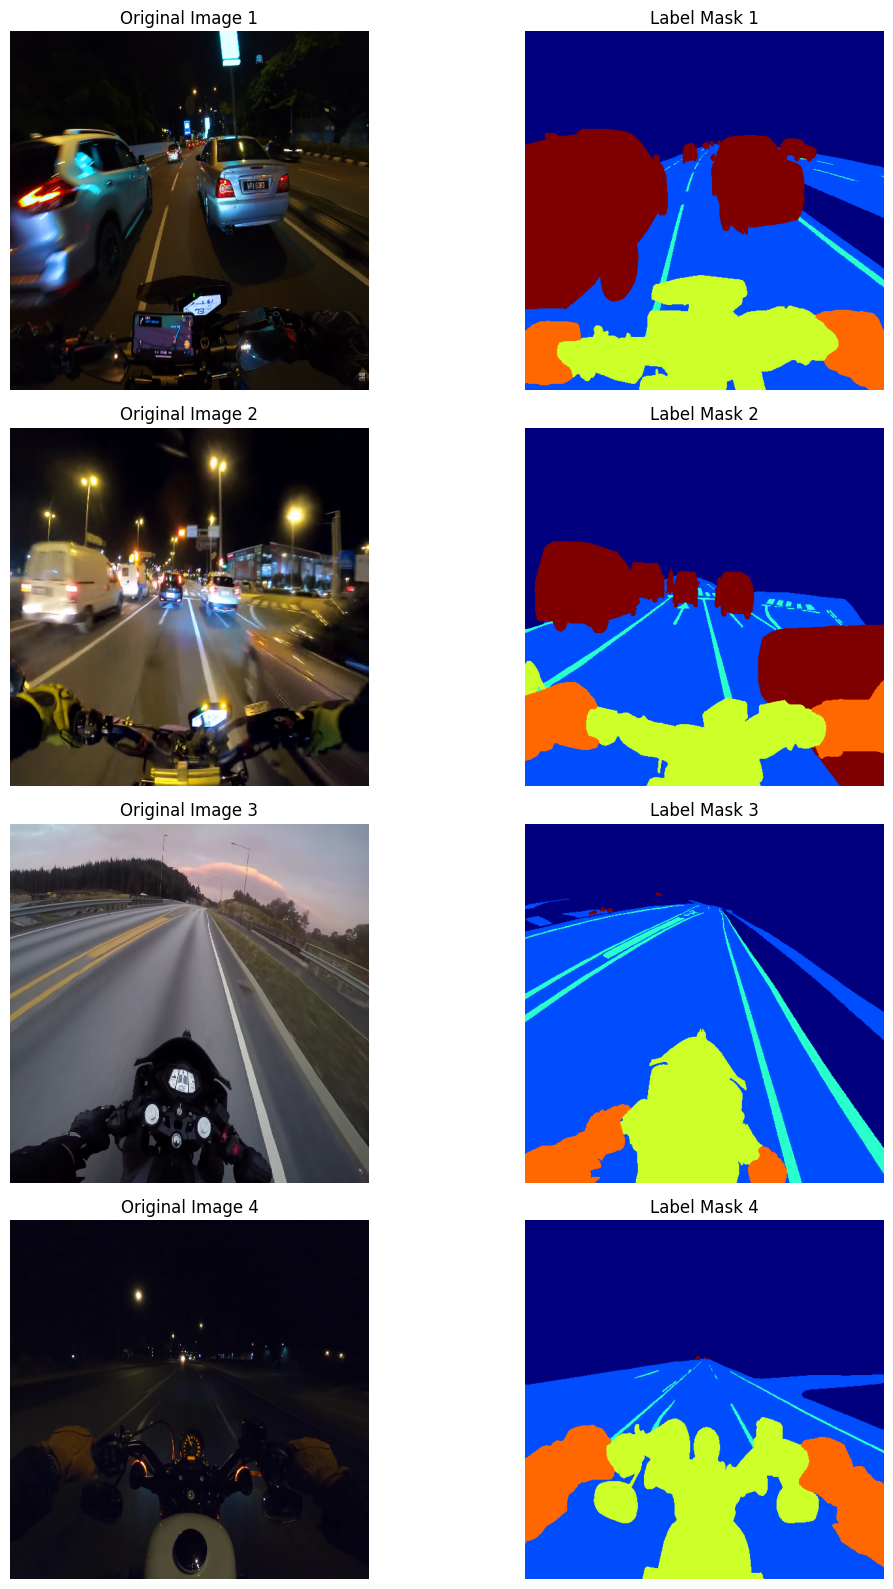

In [18]:
import matplotlib.pyplot as plt

def visualize_batch(loader, class_map):
    """마스크가 제대로 생성되었는지 시각화"""
    # 1. 배치 하나 추출
    images, masks = next(iter(loader))

    # 역매핑 생성 (숫자 -> 클래스 이름)
    id_to_name = {v: k for k, v in class_map.items()}

    # 시각화 설정 (4장 기준)
    fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(12, 16))

    for i in range(4):
        # 이미지 전처리(Normalize) 되돌리기 (시각화 용도)
        img = images[i].permute(1, 2, 0).numpy()
        img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
        img = np.clip(img, 0, 1)

        # 마스크 데이터
        mask = masks[i].numpy()

        # 출력
        axes[i, 0].imshow(img)
        axes[i, 0].set_title(f"Original Image {i+1}")
        axes[i, 0].axis('off')

        # 마스크 시각화 (클래스별로 색이 다르게 보이도록 cmap 설정)
        im = axes[i, 1].imshow(mask, cmap='jet', vmin=0, vmax=len(class_map)-1)
        axes[i, 1].set_title(f"Label Mask {i+1}")
        axes[i, 1].axis('off')

    plt.tight_layout()
    plt.show()

# 실행
visualize_batch(train_loader, CLASS_MAP)

## Step.2 - 모델 구현

### 2-01. 모델 선언

#### 1) DeepLabV3

In [19]:
from torchvision.models.segmentation import deeplabv3_resnet50 # 50개층 사용
# from torchvision.models.segmentation import deeplabv3_resnet101 # 101개층 사용

class DeepLabV3_basic:
    def __init__(self, num_classes: int = 6, device: str = 'cuda'):
        self.device = torch.device(device if torch.cuda.is_available() else 'cpu')
        self.num_classes = num_classes
        self.model = self._get_model()
        self.model.to(self.device)

    def _get_model(self):
        # 모델 로드
        model = deeplabv3_resnet50(weights='DEFAULT')

        # 메인 분류기 수정
        in_channels = model.classifier[4].in_channels
        model.classifier[4] = nn.Conv2d(in_channels, self.num_classes, kernel_size=(1, 1))

        # 보조 분류기 수정
        in_channels_aux = model.aux_classifier[4].in_channels
        model.aux_classifier[4] = nn.Conv2d(in_channels_aux, self.num_classes, kernel_size=(1, 1))

        return model

    def save_model(self, path):
        torch.save(self.model.state_dict(), path)
        print(f"Model saved to {path}")

### 2-02. 모델 인스턴스 생성

In [21]:
model_manager = DeepLabV3_basic(num_classes=6)
model = model_manager.model  # 실제 학습에 사용될 모델 객체

Downloading: "https://download.pytorch.org/models/deeplabv3_resnet50_coco-cd0a2569.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_resnet50_coco-cd0a2569.pth


100%|██████████| 161M/161M [00:01<00:00, 150MB/s]


### 2-02. 손실함수 및 최적화 설정

손실함수  
  - Dice Loss: 클래스 불균형 해결
  - 야간 주행 영상에서 '차선(Lanemark)'은 전체 픽셀의 1%도 안 될 수 있음.
  픽셀 개별의 정답 여부만 따지는 CrossEntropy의 한계를 극복하기 위해, 예측 영역과 실제 영역의 교집합을 극대화하는 Dice Loss는 작은 객체도 놓치지 않게 만듦.

- Cross Entropy Loss:
  - 모든 픽셀에 대해 개별적으로 정답 여부를 판별
  - CrossEntropy만 쓰면 모델은 차선을 틀려도 전체 점수에 영향이 적다고 판단해 차선을 포기해버림.

옵티마이저  
- AdamW:
  - Adam에 가중치 감쇠(Weight Decay)를 개선한 알고리즘. 과적합 방지에 탁월.
  - 적은 데이터(200장)에서 모델이 노이즈까지 외워버리는 현상을 수학적으로 억제하여 모델의 성능을 일반화 해줌.

In [22]:
# 1. Dice Loss 정의 (클래스 불균형 해결사)
class DiceLoss(torch.nn.Module):
    def __init__(self, smooth=1e-6):
        super(DiceLoss, self).__init__()
        self.smooth = smooth

    def forward(self, predict, target):
        # predict: (Batch, 6, H, W), target: (Batch, H, W)
        predict = torch.softmax(predict, dim=1)

        # 정답(target)을 One-hot 인코딩으로 변환 (Batch, 6, H, W)
        target_one_hot = torch.nn.functional.one_hot(target, num_classes=6).permute(0, 3, 1, 2).float()

        intersection = (predict * target_one_hot).sum(dim=(0, 2, 3))
        union = predict.sum(dim=(0, 2, 3)) + target_one_hot.sum(dim=(0, 2, 3))

        dice = (2. * intersection + self.smooth) / (union + self.smooth)
        return 1 - dice.mean()

# 2. 손실함수 선언
criterion_ce = torch.nn.CrossEntropyLoss()
criterion_dice = DiceLoss()

# 3. 옵티마이저 설정
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-2)

# 학습률 스케줄러: 학습이 진행됨에 따라 학습률을 조금씩 낮춰 정교하게 수렴하도록 함.
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)

### 2-03. 에포크 설정

In [23]:
# AdamW와 Dice + CE 복합 손실 함수를 사용
def train_one_epoch(model, dataloader, optimizer, criterion_ce, criterion_dice, device):
    model.train()
    running_loss = 0.0

    for images, masks in dataloader:
        images = images.to(device)
        masks = masks.to(device) # (Batch, H, W)

        optimizer.zero_grad() # 그래디언트 초기화

        # 1. Forward Pass
        outputs = model(images)['out'] # (Batch, 6, H, W)

        # 2. Loss 계산
        loss_ce = criterion_ce(outputs, masks)
        loss_dice = criterion_dice(outputs, masks)

        # 3. Backward Pass & Optimize
        # 3-1. (Dice 단독 손실)
        # loss_dice.backward() # loss_dice.backward()만 실행되어 CE 손실은 학습에 전혀 반영되지 않음 (주석처리)

        # 3-2. (CE + Dice 복합 손실)
        loss_combined = (0.5 * loss_ce) + (0.5 * loss_dice) # 1:1 비율로 혼합
        loss_combined.backward()

        # 4. Optimize
        optimizer.step()

        # 기록은 결합 손실로 변경
        # running_loss += loss_dice.item()
        running_loss += loss_combined.item()

    return running_loss / len(dataloader)

# --- 실제 학습 실행부 ---
# 데이터가 200장이므로 에폭을 충분히 가져가되 과적합 주의
num_epochs = 30
best_loss = float('inf')

# 실행부는 아래 모델 트레이너 객체로 대신함
# for epoch in range(num_epochs):
#     # 훈련 세트로 학습
#     train_loss = train_one_epoch(model, train_loader, optimizer, criterion_ce, criterion_dice, device)

#     # [검증 파트 - 기능 구현 팀에게 요청할 부분]
#     # val_loss = validate(model, val_loader, criterion_ce, criterion_dice, device)

#     scheduler.step() # 학습률 조정

#     print(f"Epoch [{epoch+1}/{num_epochs}] - Loss: {train_loss:.4f}")

#     # 최적 모델 저장 (Early Stopping 대용)
#     if train_loss < best_loss:
#         best_loss = train_loss
#         # torch.save(model.state_dict(), 'best_model_resnet50.pth')
#         save_path = pm.get_model_path('best_model_resnet50.pth')
#         torch.save(model.state_dict(), save_path)
#         print(f"✨ Model Saved to: {save_path}")

### 2-04. 모델 트레이너 객체 선언

In [24]:
import torch

class ModelTrainer:
    def __init__(self, model, train_loader, val_loader, optimizer, scheduler,
                 criterion_ce, criterion_dice, device, path_manager):
        """
        학습에 필요한 모든 요소와 경로 관리자를 주입받습니다.
        """
        self.model = model
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.optimizer = optimizer
        self.scheduler = scheduler
        self.criterion_ce = criterion_ce
        self.criterion_dice = criterion_dice
        self.device = device
        self.pm = path_manager # PathManager 인스턴스

        self.best_loss = float('inf')
        self.history = {'train_loss': [], 'val_loss': []}

    def train(self, num_epochs=30):
        """전체 에포크 학습 실행"""
        print(f"🚀 학습 시작 (Device: {self.device})")

        for epoch in range(num_epochs):
            # 1. 한 에포크 학습
            train_loss = self._train_one_epoch()
            self.history['train_loss'].append(train_loss)

            # 2. 검증 (현재는 placeholder, 필요시 구현)
            # val_loss = self._validate()
            # self.history['val_loss'].append(val_loss)

            # 3. 스케줄러 업데이트
            self.scheduler.step()

            print(f"Epoch [{epoch+1}/{num_epochs}] - Loss: {train_loss:.4f}")

            # 4. 최적 모델 저장 (PathManager 활용)
            if train_loss < self.best_loss:
                self.best_loss = train_loss
                self._save_checkpoint(epoch, train_loss)

        print("✅ 모든 학습이 완료되었습니다.")

    def _train_one_epoch(self):
        """내부용: 단일 에포크 학습 로직"""
        self.model.train()
        running_loss = 0.0

        for images, masks in self.train_loader:
            images = images.to(self.device)
            masks = masks.to(self.device)

            self.optimizer.zero_grad()

            # Forward Pass (DeepLabV3 특성상 'out' 사용)
            outputs = self.model(images)['out']

            # Loss 계산
            loss_ce = self.criterion_ce(outputs, masks)
            loss_dice = self.criterion_dice(outputs, masks)
            loss_combined = (0.5 * loss_ce) + (0.5 * loss_dice)

            # Backward & Optimize
            loss_combined.backward()
            self.optimizer.step()

            running_loss += loss_combined.item()

        return running_loss / len(self.train_loader)

    def _save_checkpoint(self, epoch, loss):
        """PathManager를 사용하여 모델 저장"""
        # PathManager에 정의된 경로 활용
        save_path = self.pm.get_model_path('best_model_resnet50.pth')

        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': self.model.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'loss': loss,
        }, save_path)

        print(f"✨ 최고 성능 달성! 모델 저장 완료: {save_path}")

### 2-05. 새니티 체크(Sanity Check)

- 목적: 모델이 제정신인지 체크하는 과정  
- 데이터: 실제 이미지 한장
- 성공기준: Loss가 0에 가깝게 수렴하는지
---
DeepLabv3+ 내부에는 데이터들의 평균(\mu)과 분산(\sigma^2)을 계산해서 숫자를 정규화하는 Batch Normalization(BN) 층이 아주 많다.
우리는 Batch Size = 1 (이미지 딱 한 장)로 학습(model.train()) 하기 때문에 데이터가 딱 하나뿐이라 분산을 계산할 수 없다. 수학적으로 분산을 구하려면 최소 2개 이상의 데이터가 필요하다.

 해결책: BatchNorm만 '평가 모드'로 속이기
 모델 전체는 train() 모드로 두되, Batch Normalization 층들만 eval() 모드로 고정한다.   이렇게 하면 모델은 학습을 계속하면서도, BN 층은 미리 학습된(ImageNet) 통계치를 사용하여 에러를 내지 않는다.

In [ ]:

# 1. COCO JSON에서 img1_RGB의 정답(Annotation) 찾아 마스크 만들기
def get_target_mask_from_json(json_path, target_file_name, img_size=(512, 512)):
    with open(json_path, 'r') as f:
        data = json.load(f)

    # 해당 파일명의 이미지 ID 찾기
    img_id = None
    for img in data['images']:
        if img['file_name'] == target_file_name:
            img_id = img['id']
            orig_h, orig_w = img['height'], img['width']
            break

    if img_id is None:
        print(f"❌ {target_file_name}을 JSON에서 찾을 수 없습니다.")
        return None

    # 클래스 맵핑 (우리 프로젝트 규격)
    class_map = {'background': 0, 'road': 1, 'lane': 2, 'rider': 3, 'bike': 4, 'movable': 5}
    cat_id_to_name = {cat['id']: cat['name'].lower() for cat in data['categories']}

    # 빈 마스크 생성 (원본 크기)
    mask = np.zeros((orig_h, orig_w), dtype=np.uint8)

    # 좌표(Polygon) 그리기
    for ann in data['annotations']:
        if ann['image_id'] == img_id:
            cat_name = cat_id_to_name[ann['category_id']]
            class_idx = class_map.get(cat_name, 0)
            for seg in ann['segmentation']:
                poly = np.array(seg).reshape((-1, 2)).astype(np.int32)
                cv2.fillPoly(mask, [poly], class_idx)

    # 모델 입력 크기(512x512)로 리사이즈 (반드시 NEAREST 사용)
    mask_resized = cv2.resize(mask, img_size, interpolation=cv2.INTER_NEAREST)
    return torch.from_numpy(mask_resized).long().to(device).unsqueeze(0) # (1, 512, 512)

# 모델 전체는 train() 모드로 두되, Batch Normalization 층들만 eval() 모드로 고정
def set_train_mode(model):
    model.train() # 전체 모델은 학습 모드
    for m in model.modules():
        if isinstance(m, torch.nn.modules.batchnorm._BatchNorm):
            m.eval() # BatchNorm 층만 평가 모드로 고정 (분산 계산 방지)
            m.weight.requires_grad = False # 가중치 업데이트 중단 (선택 사항)
            m.bias.requires_grad = False

# --- 실행 파트 ---
# 실험용 이미지 한장
target_file_name = 'Screenshot (309).png'

target_mask = get_target_mask_from_json(json_path, target_file_name)


if target_mask is not None:
    # 2. 실시간 과적합 학습 및 그래프 시각화
    set_train_mode(model)
    losses = []

    print("🚀 실시간 Sanity Check 시작...")
    plt.figure(figsize=(10, 5))

    for i in range(100):
        optimizer.zero_grad()
        outputs = model(input_tensor)['out']
        loss = (0.5 * criterion_ce(outputs, target_mask)) + (0.5 * criterion_dice(outputs, target_mask))

        loss.backward()
        optimizer.step()
        losses.append(loss.item())

        # 10회마다 그래프 업데이트 (코랩에서 실시간 확인용)
        if (i+1) % 10 == 0:
            plt.clf()
            plt.plot(losses, label='Total Loss')
            plt.title(f"Iteration {i+1}/100 - Loss: {loss.item():.4f}")
            plt.xlabel("Iteration"); plt.ylabel("Loss")
            plt.legend(); plt.grid(True)
            from IPython import display
            display.clear_output(wait=True)
            display.display(plt.gcf())

    print("✅ 학습 완료! 모델이 정답을 완벽히 외웠습니다.")

#### 제대로 들어가는지 확인하기 위한 모델 정의

## Step3. 실행